In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import zipfile
import os
import pandas as pd

extraction_dir = '/kaggle/input/movie-classifier/Multi_Label_dataset'

csv_path = os.path.join(extraction_dir, 'train.csv')

df = pd.read_csv(csv_path)

df

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7249,tt2409818,"['Action', 'Crime', 'Thriller']",1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
7250,tt2062622,"['Animation', 'Comedy', 'Family']",0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7251,tt2442502,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7252,tt3455850,['Documentary'],0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
labels_names = df.drop(['Id', 'Genre'], axis = 1).columns
labels_names

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'N/A', 'News', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

In [3]:
image_names = df['Id']
image_names

multi_hot_encoding = df.drop(['Genre'], axis=1).set_index('Id').T.to_dict(orient = 'list')


/tmp/ipykernel_34/1711675911.py:4: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  multi_hot_encoding = df.drop(['Genre'], axis=1).set_index('Id').T.to_dict(orient = 'list')


In [53]:
import cv2
import numpy as np

images_dict = {}
for image_name in image_names[:500]:
    image_path = os.path.join(extraction_dir,'Images', image_name + '.jpg')
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    images_dict[image_name] = img

In [4]:
import os
import cv2
import numpy as np

# Define directories
base_dir = 'processed_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Split data into training and validation
train_size = int(len(image_names) * 0.8)
train_image_names = image_names[:train_size]
val_image_names = image_names[train_size:]

def save_images_and_labels(image_names, labels, target_dir):
    for i, image_name in enumerate(image_names):
        image_path = os.path.join(extraction_dir, 'Images', image_name + '.jpg')
        img = cv2.imread(image_path)
        img = cv2.resize(img, (224, 224))
        img_save_path = os.path.join(target_dir, image_name + '.jpg')
        cv2.imwrite(img_save_path, img)
        # Save label as .npy file
        label_save_path = os.path.join(target_dir, image_name + '.npy')
        np.save(label_save_path, labels[i])

# Save training images and labels
train_labels = [multi_hot_encoding[image_name] for image_name in train_image_names]
save_images_and_labels(train_image_names, train_labels, train_dir)

# Save validation images and labels
val_labels = [multi_hot_encoding[image_name] for image_name in val_image_names]
save_images_and_labels(val_image_names, val_labels, val_dir)


In [7]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.utils import Sequence

class MultiLabelDataGenerator(Sequence):
    def __init__(self, image_filenames, labels, batch_size, image_size):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        for file_name in batch_x:
            img = cv2.imread(file_name)
            img = cv2.resize(img, self.image_size)
            img = img / 255.0
            images.append(img)
        
        images = np.array(images)
        labels = np.array(batch_y)

        return images, labels

    def on_epoch_end(self):
        pass

def load_filenames_and_labels(directory):
    image_filenames = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            image_filenames.append(os.path.join(directory, filename))
            label_filename = filename.replace('.jpg', '.npy')
            labels.append(np.load(os.path.join(directory, label_filename)))
    return image_filenames, labels

# Load training filenames and labels
train_filenames, train_labels = load_filenames_and_labels(train_dir)

# Load validation filenames and labels
val_filenames, val_labels = load_filenames_and_labels(val_dir)

# Parameters
img_height, img_width = 224, 224
batch_size = 32

# Create data generators
train_generator = MultiLabelDataGenerator(train_filenames, train_labels, batch_size, (img_height, img_width))
val_generator = MultiLabelDataGenerator(val_filenames, val_labels, batch_size, (img_height, img_width))


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout


model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(16, (5, 5), activation='relu'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Conv2D(32, (5, 5), activation='relu'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Conv2D(64, (5, 5), activation='relu'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Conv2D(128, (5, 5), activation='relu'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Conv2D(256, (5, 5), activation='relu'),
    Dropout(0.2),
    Conv2D(256, (5, 5), activation='relu'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(25, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10  # Adjust the number of epochs as needed
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/182 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.0234 - loss: 0.7117   

I0000 00:00:1720087870.753323     138 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


182/182 ━━━━━━━━━━━━━━━━━━━━ 62s 201ms/step - accuracy: 0.1281 - loss: 0.4880 - val_accuracy: 0.1870 - val_loss: 0.2702
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.2246 - loss: 0.2730 - val_accuracy: 0.1870 - val_loss: 0.2533
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.2237 - loss: 0.2600 - val_accuracy: 0.1870 - val_loss: 0.2520
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.2302 - loss: 0.2544 - val_accuracy: 0.1870 - val_loss: 0.2521
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.2192 - loss: 0.2523 - val_accuracy: 0.1870 - val_loss: 0.2526
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.2088 - loss: 0.2523 - val_accuracy: 0.1870 - val_loss: 0.2528
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.2147 - loss: 0.2502 - val_accuracy: 0.1870 - val_loss: 0.2518
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.2016 - loss: 0.2487 - val_accura

In [54]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Input,Dropout

images = np.array([images_dict[image_name] for image_name in image_names[:500]])
labels = np.array([multi_hot_encoding[image_name] for image_name in image_names[:500]])

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

X_train = X_train / 255.0
X_test = X_test / 255.0

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
datagen.fit(X_train)

In [33]:

model = Sequential([
    Input(shape=(400, 400, 3)),
    Conv2D(16, (5, 5), activation='relu'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Conv2D(32, (5, 5), activation='relu'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Conv2D(64, (5, 5), activation='relu'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Conv2D(128, (5, 5), activation='relu'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Conv2D(256, (5, 5), activation='relu'),
    Dropout(0.2),
    Conv2D(256, (5, 5), activation='relu'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(labels[0]), activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','top_k_categorical_accuracy'])
model.optimizer.learning_rate.assign(0.001)



In [34]:
print(X_test[0].shape)
model.summary()

(400, 400, 3)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 396, 396, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 396, 396, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 198, 198, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 194, 194, 32)   │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 194, 194, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 97, 97, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 93, 93, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 93, 93, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 42, 42, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 17, 17, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 13, 13, 256)    │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 25)             │         1,62

 Total params: 3,922,169 (14.96 MB)

 Trainable params: 3,922,169 (14.96 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#iterate through sections of the data to split it up into the test and train and progrtessivley train the model one section of data at a time, sections of 500

In [ ]:
model.fit(X_train, y_train, batch_size = 64, epochs=100)

In [21]:
loss, accuracy, top5 = model.evaluate(X_test, y_test, batch_size = 64)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
print('Test Top5 Accuracy:', top5)

predictions = model.predict(X_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.2656 - loss: 0.2683 - top_k_categorical_accuracy: 0.8281

W0000 00:00:1720084938.402801     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 12s/step - accuracy: 0.2485 - loss: 0.2708 - top_k_categorical_accuracy: 0.8227


W0000 00:00:1720084950.662333     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Loss: 0.2720918357372284
Test Accuracy: 0.23999999463558197
Test Top5 Accuracy: 0.8199999928474426
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 904ms/step


W0000 00:00:1720084965.065705     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import tensorflow as tf
ResNet50_model = ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

x = ResNet50_model.output
x = tf.keras.layers.Flatten()(x)
predictions = tf.keras.layers.Dense(25, activation='sigmoid')(x)
TL_model = Model(inputs = ResNet50_model.input, outputs = predictions)

TL_model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])


In [17]:
for layer in ResNet50_model.layers:
    layer.trainable = False

In [24]:
TL_model.fit(train_generator,
    validation_data=val_generator, epochs=25, batch_size=64)

Epoch 1/25


W0000 00:00:1720090045.906881     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.3070 - loss: 0.5354 - top_k_categorical_accuracy: 0.7206

W0000 00:00:1720090123.894369     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 152s 460ms/step - accuracy: 0.3072 - loss: 0.5342 - top_k_categorical_accuracy: 0.7208 - val_accuracy: 0.1870 - val_loss: 0.2692 - val_top_k_categorical_accuracy: 0.2712
Epoch 2/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 55s 300ms/step - accuracy: 0.4012 - loss: 0.2131 - top_k_categorical_accuracy: 0.8151 - val_accuracy: 0.0490 - val_loss: 0.3095 - val_top_k_categorical_accuracy: 0.5700
Epoch 3/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 55s 299ms/step - accuracy: 0.4172 - loss: 0.1980 - top_k_categorical_accuracy: 0.8315 - val_accuracy: 0.0725 - val_loss: 0.3198 - val_top_k_categorical_accuracy: 0.2850
Epoch 4/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 55s 300ms/step - accuracy: 0.4776 - loss: 0.1631 - top_k_categorical_accuracy: 0.8906 - val_accuracy: 0.2264 - val_loss: 0.2742 - val_top_k_categorical_accuracy: 0.5707
Epoch 5/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 82s 299ms/step - accuracy: 0.4944 - loss: 0.1225 - top_k_categorical_accuracy: 0.9444 - val_accuracy: 0.2091 - val_loss: 0.3313 - val_

In [15]:
loss, accuracy, top5 = TL_model.evaluate(X_test, y_test, batch_size = 64)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
print('Test Top5 Accuracy:', top5)

predictions_TL = TL_model.predict(X_test)

W0000 00:00:1720083307.736217     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 353ms/step - accuracy: 0.2784 - loss: 0.8030 - top_k_categorical_accuracy: 0.7014
Test Loss: 0.8070825934410095
Test Accuracy: 0.26499998569488525
Test Top5 Accuracy: 0.699999988079071
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step


In [45]:
fully_connected = Sequential([
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dense(25, activation='sigmoid') 
])(x)

dense_model = Model(inputs = ResNet50_model.input, outputs = fully_connected)

dense_model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy','top_k_categorical_accuracy'])

In [46]:
dense_model.fit(train_generator,
    validation_data=val_generator, epochs=10, batch_size=64)

Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 145s 471ms/step - accuracy: 0.2405 - loss: 0.3467 - top_k_categorical_accuracy: 0.5730 - val_accuracy: 0.3368 - val_loss: 0.2539 - val_top_k_categorical_accuracy: 0.6825
Epoch 2/10


W0000 00:00:1720093728.894649     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 57s 310ms/step - accuracy: 0.4240 - loss: 0.2230 - top_k_categorical_accuracy: 0.7795 - val_accuracy: 0.2905 - val_loss: 0.2593 - val_top_k_categorical_accuracy: 0.6253
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 57s 311ms/step - accuracy: 0.4344 - loss: 0.2075 - top_k_categorical_accuracy: 0.7992 - val_accuracy: 0.2560 - val_loss: 0.3292 - val_top_k_categorical_accuracy: 0.5445
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 57s 310ms/step - accuracy: 0.4815 - loss: 0.1915 - top_k_categorical_accuracy: 0.8293 - val_accuracy: 0.2650 - val_loss: 0.2808 - val_top_k_categorical_accuracy: 0.6998
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 57s 311ms/step - accuracy: 0.4937 - loss: 0.1831 - top_k_categorical_accuracy: 0.8688 - val_accuracy: 0.3057 - val_loss: 0.2760 - val_top_k_categorical_accuracy: 0.6342
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 57s 311ms/step - accuracy: 0.5290 - loss: 0.1650 - top_k_categorical_accuracy: 0.8819 - val_accuracy: 0.2968 - val_loss: 0.2936 - val_t

In [41]:
loss, accuracy , top5 = dense_model.evaluate(X_test, y_test, batch_size = 64)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
print('Test Top5 Accuracy:', top5)

predictions_dense = dense_model.predict(X_test)

NameError: name 'X_test' is not defined

In [47]:
def GenrePrediction(predictions):
    print(predictions)
    predictions = np.array(predictions)

    top_indices = np.argsort(predictions)[0][-3:]
    top_values = predictions[0][top_indices]


    diff1 = np.abs(top_values[2] - top_values[1])
    diff2 = np.abs(top_values[0] - top_values[1])
    
    classification = []

    threshold = np.std(predictions)
   
    if diff1 > threshold:
        print(top_values[2])
        classification.append(labels_names[top_indices[2]])
    elif diff1 <= threshold and diff2 > threshold:
        print(top_values[2])
        print(top_values[1])
        classification.append(labels_names[top_indices[2]])
        classification.append(labels_names[top_indices[1]])
    else:
        print(top_values[2])
        print(top_values[1])
        print(top_values[0])
        classification.append(labels_names[top_indices[2]])
        classification.append(labels_names[top_indices[1]])
        classification.append(labels_names[top_indices[0]])

    return classification



[[1.7664310e-01 1.1278649e-01 2.1543810e-02 4.0775757e-02 4.1756195e-01
  1.7053936e-01 5.3208873e-02 5.1941532e-01 5.2136157e-02 5.3351071e-02
  1.9878861e-02 5.3040955e-02 3.1288169e-02 8.4052840e-03 5.7643894e-02
  8.6669379e-04 4.2251189e-04 4.6887842e-04 1.8834148e-01 4.2972639e-02
  2.5386128e-03 2.0378586e-02 1.1363007e-01 1.4827240e-02 3.6696191e-03]]
0.5194153
0.41756195
['Drama', 'Comedy']
[[0.19322686 0.13056341 0.03143638 0.05514381 0.41619432 0.18617055
  0.06726902 0.51511866 0.06501479 0.0698805  0.02881799 0.06899173
  0.04329779 0.01389509 0.07160475 0.00183667 0.0009117  0.00093634
  0.19972537 0.05812657 0.00418101 0.03049434 0.13313657 0.02212854
  0.00627283]]
0.51511866
0.41619432
['Drama', 'Comedy']
[[0.19268729 0.12979272 0.03101325 0.05462842 0.4161412  0.1856703
  0.06670695 0.5151881  0.0644668  0.06922705 0.02840914 0.06836022
  0.04284074 0.01364516 0.07106861 0.00178717 0.00088671 0.00091189
  0.19936948 0.05746669 0.00410044 0.03002668 0.13238521 0.021830

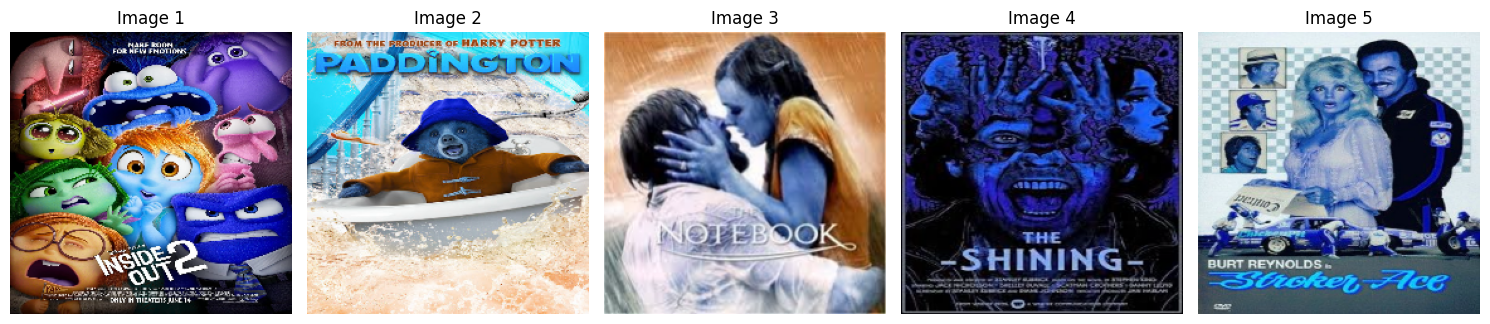

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

test_images = ['inside_out_2', 'paddington', 'notebook','shining', 'tt0086379']
prediction_imgs = {}
for image_name in test_images:
    image_path = os.path.join('/kaggle/input/predictionimage', image_name + '.jpg')
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    prediction_imgs[image_name] = img
    
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
i = 0
for img_name in test_images:
    axs[i].imshow(prediction_imgs[img_name])
    axs[i].axis('off') 
    axs[i].set_title(f"Image {i+1}")
    img = np.expand_dims(prediction_imgs[img_name], axis =0)
    pred = model.predict(img, verbose = 0)
    IO2_Genre = GenrePrediction(pred)
    print(IO2_Genre)
    i+=1

plt.tight_layout()
plt.show()

In [28]:


inside_out = TL_model.predict(prediction_imgs['inside_out_2'])

IO2_Genre = GenrePrediction(inside_out)
IO2_Genre

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0.]]
1.0


['Romance']

In [57]:
import sklearn.linear_model as lm
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt


#raw_model = lm.LogisticRegression().fit(x_train, y_train)
#print(model.score(X_test, y_test))

conf = multilabel_confusion_matrix(y_test, model.predict(X_test)) 
ConfusionMatrixDisplay(conf).plot()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets